# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [12]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pl.Config().set_tbl_rows(100)
pl.Config().set_tbl_cols(100)

polars.config.Config

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [14]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: 
Ну мы использовали функцию __predict_proba__, которая нам даёт вероятности с которыми данный объект принимает значения 0 и 1.

Мы поставили срез[:,1] поэтому мы смотрим на вероятности принятия еденицы, если хотим получить конкретные значения, тогда просто можем поставить учловие, если вероятност больше заданного значения то 1, если меньше то 0, но нам интересно смотреть на вероятности

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [15]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


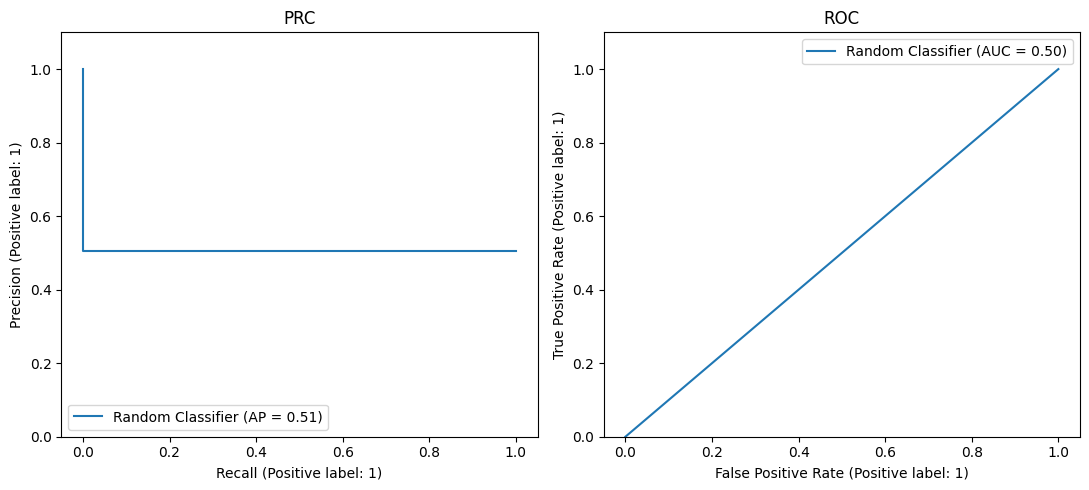

In [16]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [17]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [19]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = np.logspace(-1, 4, 20)
grid_searcher = GridSearchCV(LinearSVC(), [{"C": grid}], scoring='average_precision', cv=10)
grid_searcher.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid=[{'C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04])}],
             scoring='average_precision')

In [20]:
print("Best C parameter:", grid_searcher.best_params_)

Best C parameter: {'C': 0.1}


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


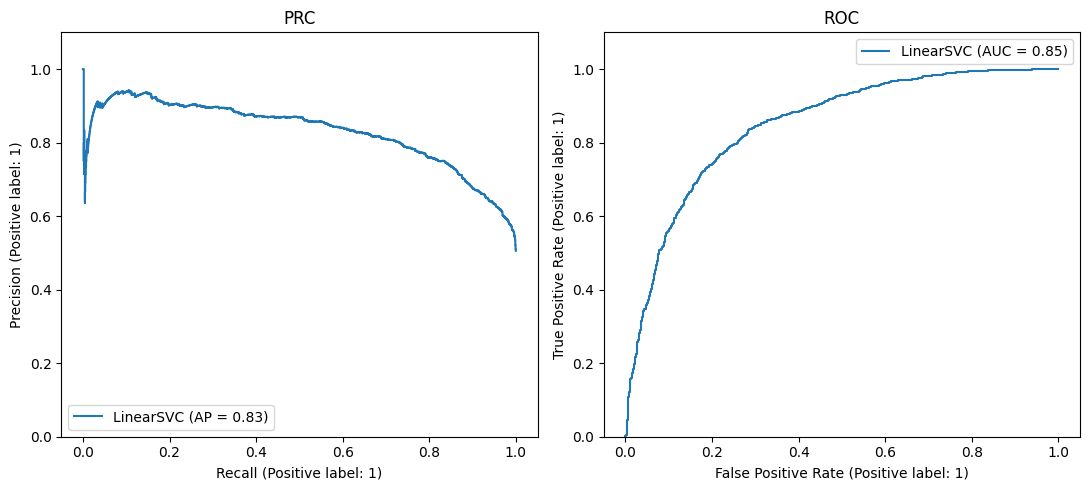

In [22]:
best_C = grid_searcher.best_params_['C']
svc_model = grid_searcher.best_estimator_
svc_model.fit(X_train, y_train)
y_pred = svc_model.decision_function(X_test)
depict_pr_roc(y_test, y_pred, 'LinearSVC')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

**Ответ:**

***PRC*** с увеличением порога (чем больше попадает данных в Psitive, вообще на семе говорили что мы понижаем порог но ок пусть так), наше покрытие (recal) модели становится больше, потому что мы зачисляем в 1 объекты всё с меньшей вероятностью, но с другой стороны точность нашей модели - на сколько мы можем ей доверять (precision) падает, поскольку мы уже объекты, которые по хорошему надо кидать в 0 кидаем в 1. Функция всегда монотонно не возратает, по описанным выше причинам, имеет неидеальные "петли" или "перепады", но в целом, при постепенном увеличении порога, точность будет пониажться, а полнота — повышаться. Думаю в нашем случае перепады это МОПовцы, которые очень похожи на РСников, поэтому модель ошибается (выбросы короче)

***POC*** с увеличеием порога мы всё больше закидываем элементы в 1 тогда TPR растёт, но когда порог уже очень большой (много элементов считаем за 1), тогда появляются ошибки FP, поэтому уже начинает увеличиваться FPR. Функция всегда монотонно не убывает, ну мы двигаемся либо вверх, либо вправо на каждом попорге.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_metrics.loc['LinearSVM'] = [
      average_precision_score(y_test, y_pred),
      roc_auc_score(y_test, y_pred),
      best_C,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.50000,0.0
LinearSVM,0.829949,0.84765,0.1


AUC-ROC и AUC_PR увеличились на целых 0.3 это хорошо, ну уже лучше чем просто рандом

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [24]:
from sklearn.linear_model import LogisticRegression

grid2 = np.logspace(-1, 4, 20)
grid_searcher2 = GridSearchCV(LogisticRegression(), [{"C": grid}], scoring='average_precision', cv=10)
grid_searcher2.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04])}],
             scoring='average_precision')

In [25]:
best_l2_C = grid_searcher2.best_params_['C']
print("Best C parameter:", grid_searcher.best_params_)

Best C parameter: {'C': 0.1}


Logistic Regression metrics
AUC-PR: 0.8294
AUC-ROC: 0.8478


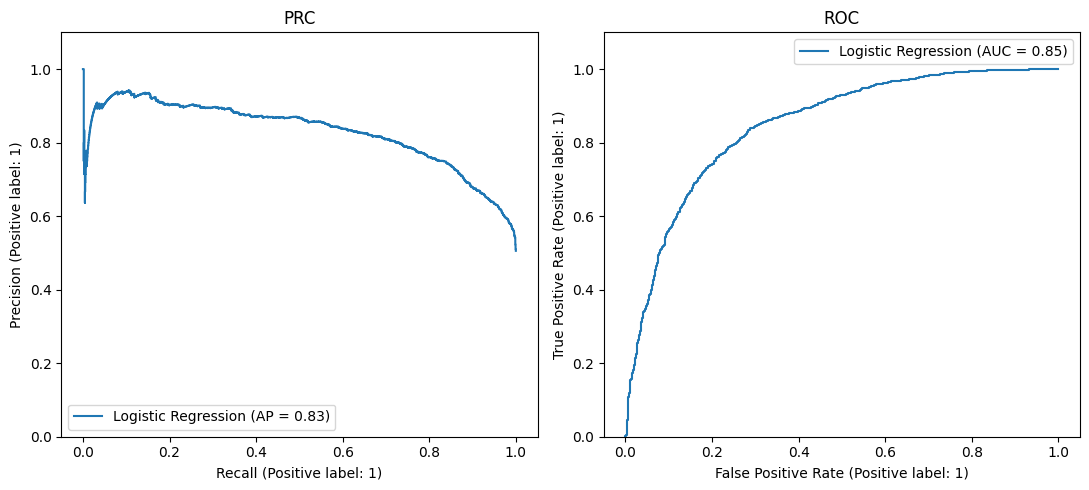

In [26]:
L2_model = grid_searcher2.best_estimator_
L2_model.fit(X_train, y_train)
y_l2_pred = L2_model.predict_proba(X_test)[:,1]
depict_pr_roc(y_test, y_l2_pred, 'Logistic Regression')

In [27]:
precision, recall, _ = precision_recall_curve(y_test, y_l2_pred)
df_metrics.loc['Logistic Regression'] = [
      average_precision_score(y_test, y_l2_pred),
      roc_auc_score(y_test, y_l2_pred),
      best_l2_C,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
LinearSVM,0.829949,0.847650,0.1
Logistic Regression,0.829431,0.847846,0.1


Относительно случайного классификатора у Logistic Regression улучшения такиже как и в случае с LinearSVM

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
SVM metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476
Logistic Regression metrics
AUC-PR: 0.8294
AUC-ROC: 0.8478


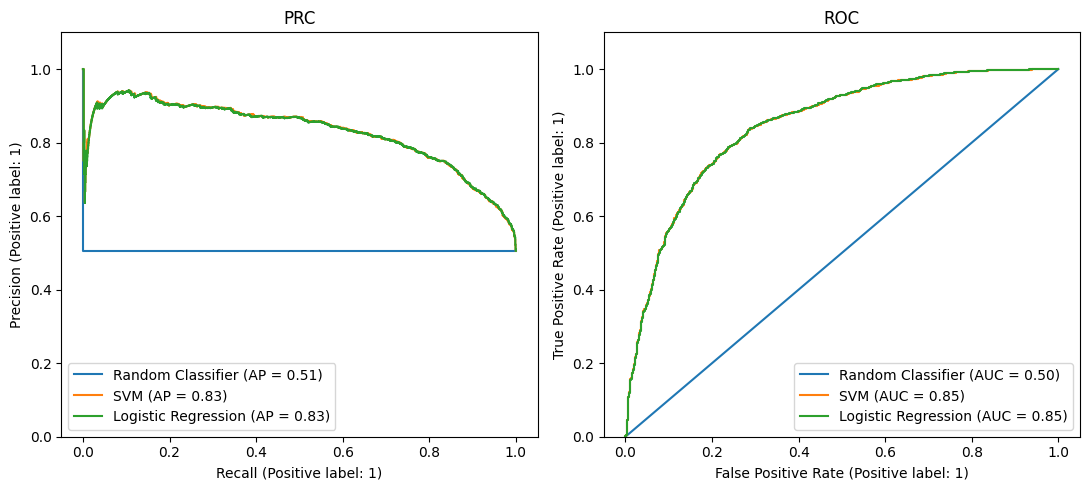

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, y_pred, 'SVM', ax=ax)
depict_pr_roc(y_test, y_l2_pred, 'Logistic Regression', ax=ax)
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** д ну отличий почти нет, графики буквально накладываются друг на друга

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [29]:
import sklearn.svm as svm
X2, y2 = make_classification(
    n_samples=10000, 
    n_features=2, 
    n_informative=2,
    n_redundant=0, 
    random_state=42
)
svm_model2 = svm.SVC(kernel='linear', probability=True)
svm_model2 = svm_model2.fit(X2, y2)

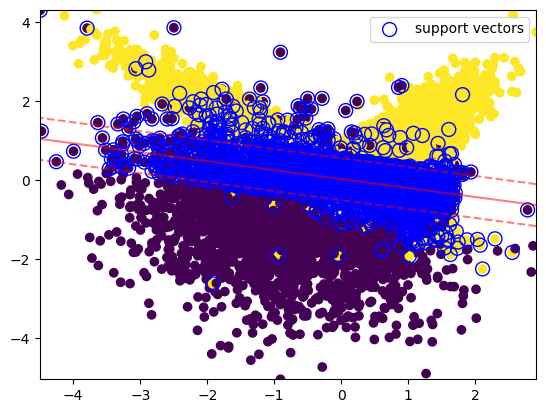

In [30]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape((30, 30))

    plt.contour(XX, YY, Z, colors='r', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=y
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X2, y2, svm_model2)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** опорными объектами выделяются те, что лежат близко к разделяющей гиперплоскости и в пределах квантиля, и те, что лежат не в своём классе

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

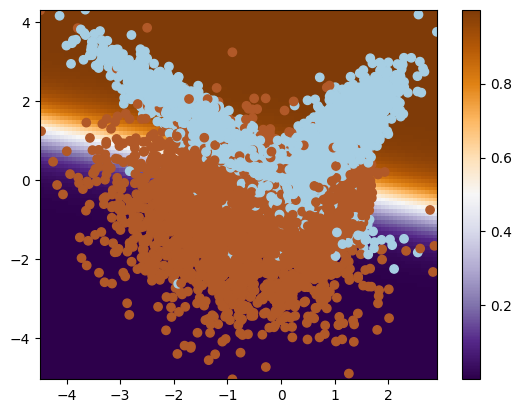

In [31]:
def plot_logreg_2D(X, y, model: LogisticRegression):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1].reshape((100, 100))
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=1 - y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

logreg_model2 = LogisticRegression()
logreg_model2 = logreg_model2.fit(X2, y2)
plot_logreg_2D(X2, y2, logreg_model2)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** ну вероятность = 0.5 в области белой полоски на фоне, там наша модель не уверена куда относить наши точки.

Теоритическое обоснование: 

Логистическая регрессия — это линейный классификатор, который использует логистическую функцию для предсказания вероятности принадлежности объекта к положительному классу $y = 1$

Для логистической регрессии вероятность того, что объект $x$ принадлежит классу **1**:
$$
p(y=+1|x) = \sigma(w^T x + b)
$$

где:
1. $\sigma(z) = \frac{1}{1 + e^{-z}}$ — логистическая функция.
2. $w^T x + b$ — линейная комбинация признаков $x$, где $w$ — вектор весов, а $b$ — bias.

Граница $p(y=+1|x) = 0.5$ достигается, когда: $\sigma(w^T x + b) = 0.5$


Логистическая функция $\sigma(z)$ принимает значение 0.5, когда $z = 0$. То есть:

$$
w^T x + b = 0
$$

Это уравнение описывает линии или гиперплоскости, которые разделяют два класса. Все точки на этой гиперплоскости имеют вероятность $p(y=+1|x) = 0.5$, что означает, что модель не может с уверенностью отнести их к одному из классов.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

я поменял тут random_state, потому что при 42 какую-то страшную вещь даёт

In [66]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=52
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

svm_model3 = svm.SVC(kernel='linear', random_state=52)
svm_model3 = svm_model3.fit(X_train, y_train)
y_pred_svm = svm_model3.decision_function(X_test) # если использовать predict_proba он сразу будет калибровать, поэтому ручками
y_pred_svm = (y_pred_svm - y_pred_svm.min()) / (y_pred_svm.max() - y_pred_svm.min())
logistic_model3= LogisticRegression(random_state=52)
logistic_model3 = logistic_model3.fit(X_train, y_train)
y_pred_logistic = logistic_model3.predict_proba(X_test)[:,1]

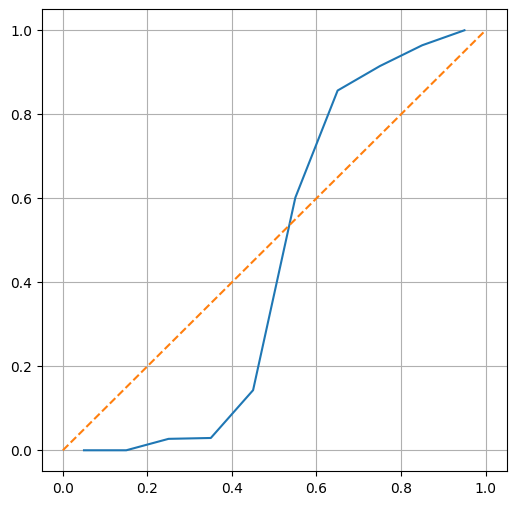

In [67]:
plot_calibration_curve(y_test, y_pred_svm)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), linestyle='--') # к чему стремимся

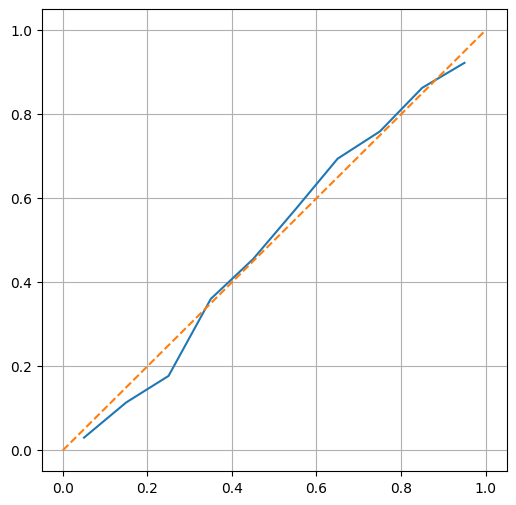

In [68]:
plot_calibration_curve(y_test, y_pred_logistic)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), linestyle='--') # к чему стремимся

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** такое ощущение, SVM хуже чем Logistic Regression. Это видно, кривая SVM местами сильно отклоняется от диагональной кривой, значит мы либо недооцениваем (если ниже), либо переоцениваем (если выше) наши вероятности. У логистической регрессии отклонения гораздо ниже, и по большей части она переоценивает на чуть-чуть(хотя бы стабильность)

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [69]:
from sklearn.metrics import log_loss, brier_score_loss

log_loss_svm = log_loss(y_test, y_pred_svm)
brier_score_svm = brier_score_loss(y_test, y_pred_svm)

log_loss_logistic = log_loss(y_test, y_pred_logistic)
brier_score_logistic = brier_score_loss(y_test, y_pred_logistic)
print(f'LogLoss для SVM: {log_loss_svm}')
print(f'BrierScore для SVM: {brier_score_svm}')
print('--------')
print(f'LogLoss для логистической регрессии: {log_loss_logistic}')
print(f'BrierScore для логистической регрессии: {brier_score_logistic}')

LogLoss для SVM: 0.5354527302421905
BrierScore для SVM: 0.17497133281473756
--------
LogLoss для логистической регрессии: 0.3875828093535269
BrierScore для логистической регрессии: 0.12006899285945573


LogLoss оценивает, насколько хорошо модель предсказывает вероятности. Он штрафует модель за уверенность в неверных предсказаниях. Чем ниже значение LogLoss, тем лучше. В нашем же случае и в SVM, и в логистической регрессии больше нуля, но меньше единицы, значит есть некоторые ошибки

Brier Score измеряет отклонение предсказанных вероятностей от реальных значений. Чем меньше значение Brier Score, тем точнее модель в предсказаниях. В нашем же случае и в SVM, и в логистической регрессии близки к нулю, вроде ок, но можно лучше

Изучите распределение ответов классификаторов при помощи гистограмм

Text(0.5, 1.0, 'Распределение ответов Logistic Regression')

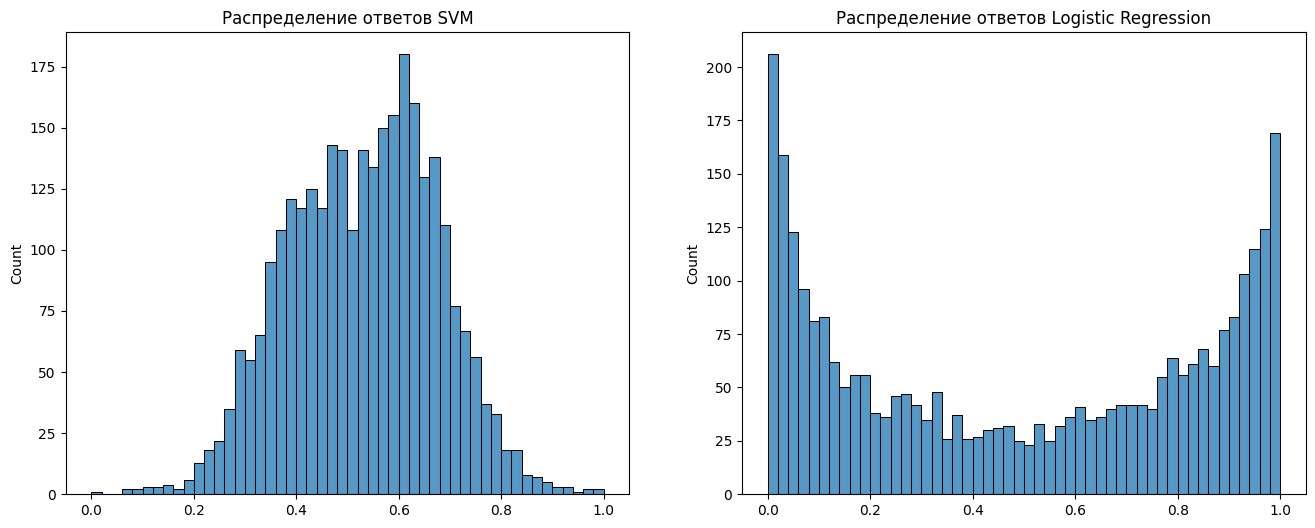

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(
    y_pred_svm,
    bins=50,
    ax=ax[0]
).set_title('Распределение ответов SVM')
sns.histplot(
    y_pred_logistic,
    bins=50,
    ax=ax[1]
).set_title('Распределение ответов Logistic Regression')

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Сразу видно, что SVM почти не уверен в своих ответах, поскольку все ответы сконцентрипованы в промежтуках от 0.4 до 0.6, в то время как Logistic Regression имеет мало ответов в районе 0.5 и много - в облостях 0 и 1. Просиходит это из-за отсутсвия калибровки у SVM, в то время как logistic откалиброваона

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [71]:
from sklearn.calibration import CalibratedClassifierCV
# калибруем
svm_model3_calibrated = CalibratedClassifierCV(svm_model3, cv=10)
# обучаем
svm_model3_calibrated = svm_model3_calibrated.fit(X_train, y_train)
# прогнозируем
y_pred_svm_calibrated = svm_model3_calibrated.predict_proba(X_test)[:, 1]

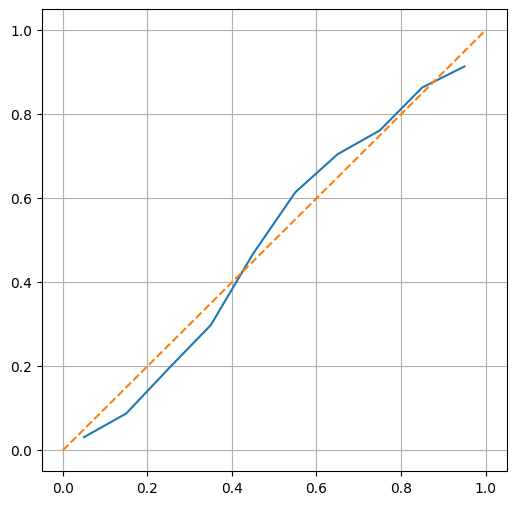

In [72]:
plot_calibration_curve(y_test, y_pred_svm_calibrated)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), linestyle='--') # к чему стремимся

Text(0.5, 1.0, 'Распределение ответов SVM с калибровкой')

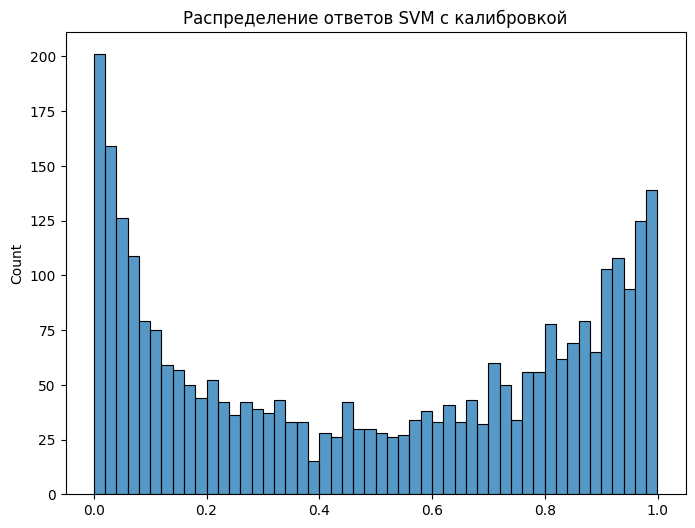

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(
    y_pred_svm_calibrated,
    bins=50,
    ax=ax
).set_title('Распределение ответов SVM с калибровкой')

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** да, модель стала ближе к диагоанльной прямой и ответы стали в разы увереннее, уменьшилось количество объектов с вероятностью от 0.4 до 0.6

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [41]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [74]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [76]:
print(path)

/Users/pavelblohin/.cache/kagglehub/datasets/heeraldedhia/bike-buyers/versions/2/bike_buyers.csv


In [77]:
df = pl.read_csv(path) # обалдеть

In [113]:
df.describe()

statistic,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
str,f64,str,str,f64,f64,str,str,str,f64,str,str,f64,str
"""count""",1000.0,"""993""","""989""",994.0,992.0,"""1000""","""1000""","""996""",991.0,"""1000""","""1000""",992.0,"""1000"""
"""null_count""",0.0,"""7""","""11""",6.0,8.0,"""0""","""0""","""4""",9.0,"""0""","""0""",8.0,"""0"""
"""mean""",19965.992,null,null,56267.605634,1.910282,null,null,null,1.455096,null,null,44.181452,null
"""std""",5347.333948,null,null,31067.817462,1.62691,null,null,null,1.121755,null,null,11.362007,null
"""min""",11000.0,"""Married""","""Female""",10000.0,0.0,"""Bachelors""","""Clerical""","""No""",0.0,"""0-1 Miles""","""Europe""",25.0,"""No"""
"""25%""",15292.0,null,null,30000.0,0.0,null,null,null,1.0,null,null,35.0,null
"""50%""",19747.0,null,null,60000.0,2.0,null,null,null,1.0,null,null,43.0,null
"""75%""",24466.0,null,null,70000.0,3.0,null,null,null,2.0,null,null,52.0,null
"""max""",29447.0,"""Single""","""Male""",170000.0,5.0,"""Partial High School""","""Skilled Manual""","""Yes""",4.0,"""5-10 Miles""","""Pacific""",89.0,"""Yes"""


In [121]:
# Прочитаем датасет
# сделал выше df

categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

# Отделим X и y
X = df.drop('ID', 'Purchased Bike')
y = (df['Purchased Bike'] == 'Yes').cast(pl.Int32)

# Разделим на категориальные признаки и числовые
X_numerical = X.drop(categorical)
X_categorical = X[categorical]
# Заменим пропуски категориальных переменных
X_categorical = X_categorical.fill_null('undefined') # Заменим пропуски категориальных переменны

В начале поработаем только с категориальными признаками

In [122]:
from sklearn.model_selection import train_test_split

X_categorical = X_categorical.to_pandas()
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [123]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
import time


column_transformer = ColumnTransformer([
    ('OrdinalEncoder', OrdinalEncoder(), categorical),
])

pipeline_logistic = Pipeline(steps=[
    ('OrdinalEncoder_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline_logistic.fit(X_train, y_train)
end = time.time()
y_pred_oe = model.decision_function(X_test)
print(f'OrdinalEncoder AUC-PR: {average_precision_score(y_test, y_pred_oe):.4f}')
print(f'OrdinalEncoder время работы: {(end - start):.4f} секунд')

OrdinalEncoder AUC-PR: 0.5883
OrdinalEncoder время работы: 0.0051 секунд


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [124]:
from sklearn.preprocessing import OneHotEncoder


column_transformer = ColumnTransformer([
    ('One_Hot_Encoding', OneHotEncoder(), categorical),
])

logistic_pipeline = Pipeline(steps=[
    ('One_Hot_Encoding_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])
start1 = time.time()
model = logistic_pipeline.fit(X_train, y_train)
end1 = time.time()
y_pred_ohe = model.decision_function(X_test)
print(f'One-Hot Encoding AUC-PR: {average_precision_score(y_test, y_pred_ohe):.4f}')
print(f'One-Hot Encoding время работы: {(end1 - start1):.4f} секунд')

One-Hot Encoding AUC-PR: 0.6666
One-Hot Encoding время работы: 0.0092 секунд


One-Hot Encoding работает дольше, тратит на это больше памяти из-за увеличения количества признаков, но как результат, но работает он получше

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [127]:
X_tr = pl.from_pandas(X_train)
y_tr = pl.DataFrame(y_train)

def mean_target_transformer(X, categorical):
    X_tmp = pl.from_pandas(X)
    data = pl.concat([X_tr, y_tr], how='horizontal') # чтобы не было переобучения
    
    for category in categorical:
        groups = data.group_by(category).agg((pl.col('Purchased Bike').mean()).alias('mean_' + category))
        X_tmp = X_tmp.join(groups, on = category, how='left').drop(category).rename({'mean_' + category : category})
    return X_tmp.to_pandas()

In [128]:
start2 = time.time()
X_train_transformed = mean_target_transformer(X_train, categorical)
logistic = LogisticRegression(random_state=42)
model = logistic.fit(X_train_transformed, y_train)
end2 = time.time()

X_test_transformed = mean_target_transformer(X_test, categorical)
y_pred_mte = model.decision_function(X_test_transformed)

print(f'Mean-target Encoding AUC-RP: {average_precision_score(y_test, y_pred_mte):.4f}')
print(f'время работы Mean-target Encoding: {(end2 - start2):.4f} секунд')

Mean-target Encoding AUC-RP: 0.6575
время работы Mean-target Encoding: 0.0101 секунд


ну работает чуть быстрее, точность чуть хуже

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [85]:
# your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [130]:
X_tr = pl.from_pandas(X_train)
y_tr = pl.DataFrame(y_train)

def mean_target_transformer2(X, categorical, var):
    X_tmp = pl.from_pandas(X)
    data = pl.concat([X_tr, y_tr], how='horizontal') # чтобы не было переобучения
    
    for category in categorical:
        groups = data.group_by(category).agg((pl.col('Purchased Bike').mean()).alias('mean_' + category))
        # создаём шум
        groups = groups.with_columns(pl.Series('noise', np.random.normal(0, np.sqrt(var), groups.shape[0])))
        groups = groups.with_columns((pl.col('mean_' + category) + pl.col('noise')).alias('mean_' + category + '_noise')).drop('mean_' + category) # добавили шум к mean_category
        X_tmp = X_tmp.join(groups, on = category, how='left').drop(category, 'noise').rename({'mean_' + category + '_noise' : category})
        
    return X_tmp.to_pandas()

In [131]:
var_grid = np.logspace(-4, 1, 20) 
logistic_noise = LogisticRegression(random_state=777)

# я не хочу ломать всю систему и разбивать тест на валидационную и тестовую, просто посмотрю возможно ли улучшение. по хорошему надо разбивать
best_auc = 0.5 # минимальный, если меньше, то зачем ты всё это делал
best_var = 0
# подбираем дисперсию, откуда я знаю какая нужна
for var in var_grid:
    X_train_transformed = mean_target_transformer2(X_train, categorical, var)
    X_test_transformed = mean_target_transformer2(X_test, categorical, var)
    model_searcher = logistic_noise.fit(X_train_transformed, y_train)
    prediction_searcher = model.decision_function(X_test_transformed)
    if (average_precision_score(y_test, prediction_searcher) > best_auc):
        best_auc = average_precision_score(y_test, prediction_searcher)
        best_var = var


start3 = time.time()
X_train_transformed = mean_target_transformer2(X_train, categorical, best_var)
model = logistic_noise.fit(X_train_transformed, y_train)
end3 = time.time()

X_test_transformed = mean_target_transformer2(X_test, categorical, best_var)
y_pred_noise = model.decision_function(X_test_transformed)


print(f'Mean-target Encoding AUC-RP с шумом: {average_precision_score(y_test, y_pred_noise):.4f}')
print(f'время работы Mean-target Encoding с шумом: {(end3 - start3):.4f} секунд')
print(f'best var: {best_var:.4f}')

Mean-target Encoding AUC-RP с шумом: 0.6902
время работы Mean-target Encoding с шумом: 0.0092 секунд
best var: 0.0006


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Позапускав код несколько раз, можно увидить как улучшения так и ухудшения: 

Иногда нам получается избавиться от переобучения с помощью добавления случайности, но по этой же причине мы можем изменить результаты предсказания в худшую сторону, минимальное что получал было AUC-RP с шумом: 0.4901, а максимальное - 0.6893

я надеюсь я сделал то что от меня хотят, но это вообще очень странно

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [88]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{globalMean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{globalMean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [132]:
X_tr = pl.from_pandas(X_train)
y_tr = pl.DataFrame(y_train)

def mean_target_transformer3(X, categorical, C):
    X_tmp = pl.from_pandas(X)
    data = pl.concat([X_tr, y_tr], how='horizontal') # чтобы не было переобучения
    globalMean = y_train.mean()
    
    for category in categorical: 
        groups = data.group_by(category).agg([(pl.col('Purchased Bike').sum()).alias('sum'), (pl.len()).alias('count')])
        groups = groups.with_columns(((pl.col('sum') + C * globalMean) / (pl.col('count') + C)).alias('globalMean_' + category))
        X_tmp = X_tmp.join(groups, on = category, how='left').drop(category, 'sum', 'count').rename({'globalMean_' + category : category})
        
    return X_tmp.to_pandas()

In [133]:
C_grid = np.logspace(-10, 10, 10)
logistic_C = LogisticRegression(random_state=94)

best_C = 0
best_auc = average_precision_score(y_test, y_pred_ohe)
# я не хочу подбирать для каждого признака, подберу общий лучше, также без валидационной
for C in C_grid:
    X_train_transformed = mean_target_transformer3(X_train, categorical, C)
    X_test_transformed = mean_target_transformer3(X_test, categorical, C)
    model_searcher = logistic_C.fit(X_train_transformed, y_train)
    prediction_searcher = model_searcher.decision_function(X_test_transformed)
    if (average_precision_score(y_test, prediction_searcher) > best_auc):
        best_auc = average_precision_score(y_test, prediction_searcher)
        best_C = C
    
start4 = time.time()
X_train_transformed = mean_target_transformer3(X_train, categorical, best_C)
model = logistic_C.fit(X_train_transformed, y_train)
end4 = time.time()

X_test_transformed = mean_target_transformer3(X_test, categorical, best_C)
y_pred_C = model.decision_function(X_test_transformed)

print(f'Mean-target Encoding AUC-RP с сглаживанием: {average_precision_score(y_test, y_pred_C):.4f}')
print(f'время работы Mean-target Encoding с сглаживанием: {(end4 - start4):.4f}')
print(f'best c: {best_C:.4f}')

Mean-target Encoding AUC-RP с сглаживанием: 0.6705
время работы Mean-target Encoding с сглаживанием: 0.0082
best c: 12.9155


Ну 0.6705 больше чем это число дъявола 0.6666, улучшили и норм

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



[Text(0.5, 0, 'Age'), Text(0, 0.5, '')]

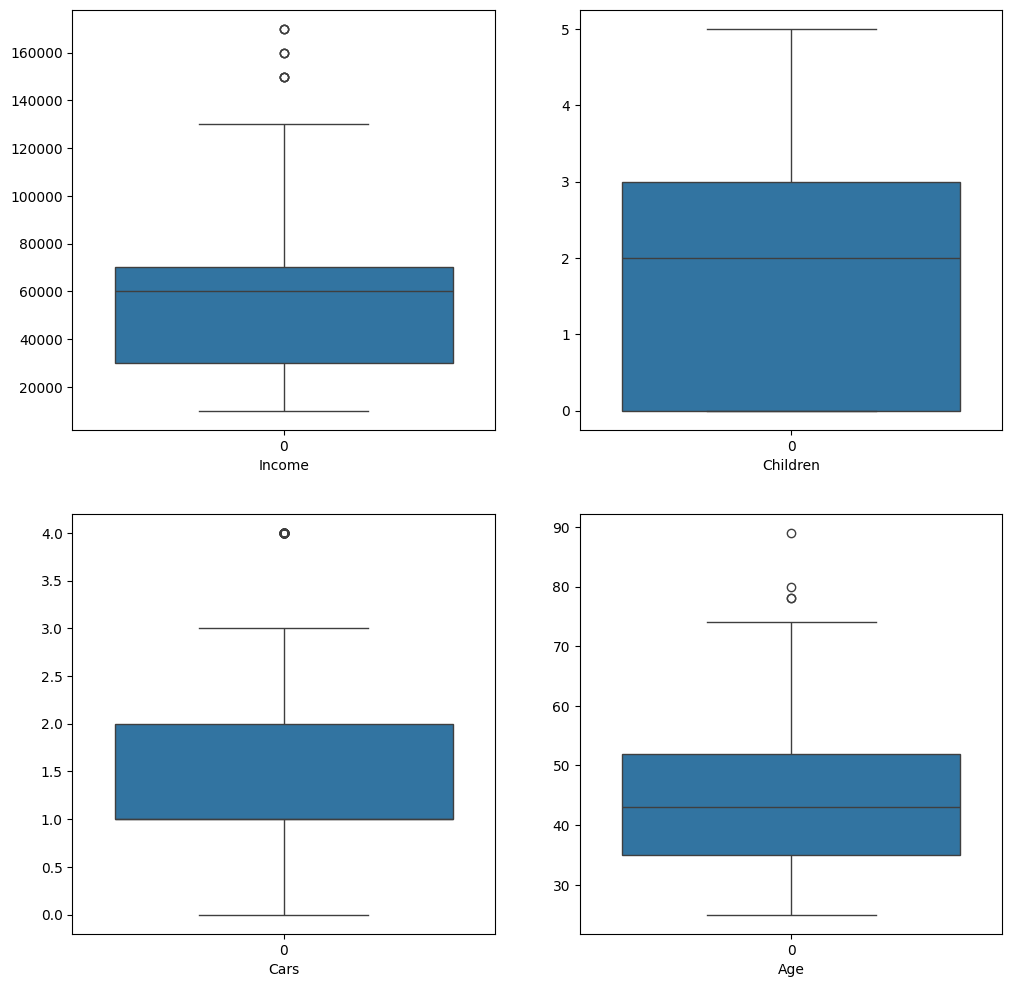

In [134]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
sns.boxplot(
    X_numerical.select('Income'), 
    ax=ax[0, 0]
).set(xlabel='Income', ylabel='')
sns.boxplot(
    X_numerical.select('Children'), 
    ax=ax[0, 1]
).set(xlabel='Children', ylabel='')
sns.boxplot(
    X_numerical.select('Cars'), 
    ax=ax[1, 0]
).set(xlabel='Cars', ylabel='')
sns.boxplot(
    X_numerical.select('Age'), 
    ax=ax[1, 1]
).set(xlabel='Age', ylabel='')

сори графики в этот раз грустные, как и мое душевное состояние во время этой домашки

выбросы есть, тогда посмотрим на распределения, если они симетричные то лучше ставить среднее, если скошены - то медиану

[Text(0.5, 0, 'Age'), Text(0, 0.5, '')]

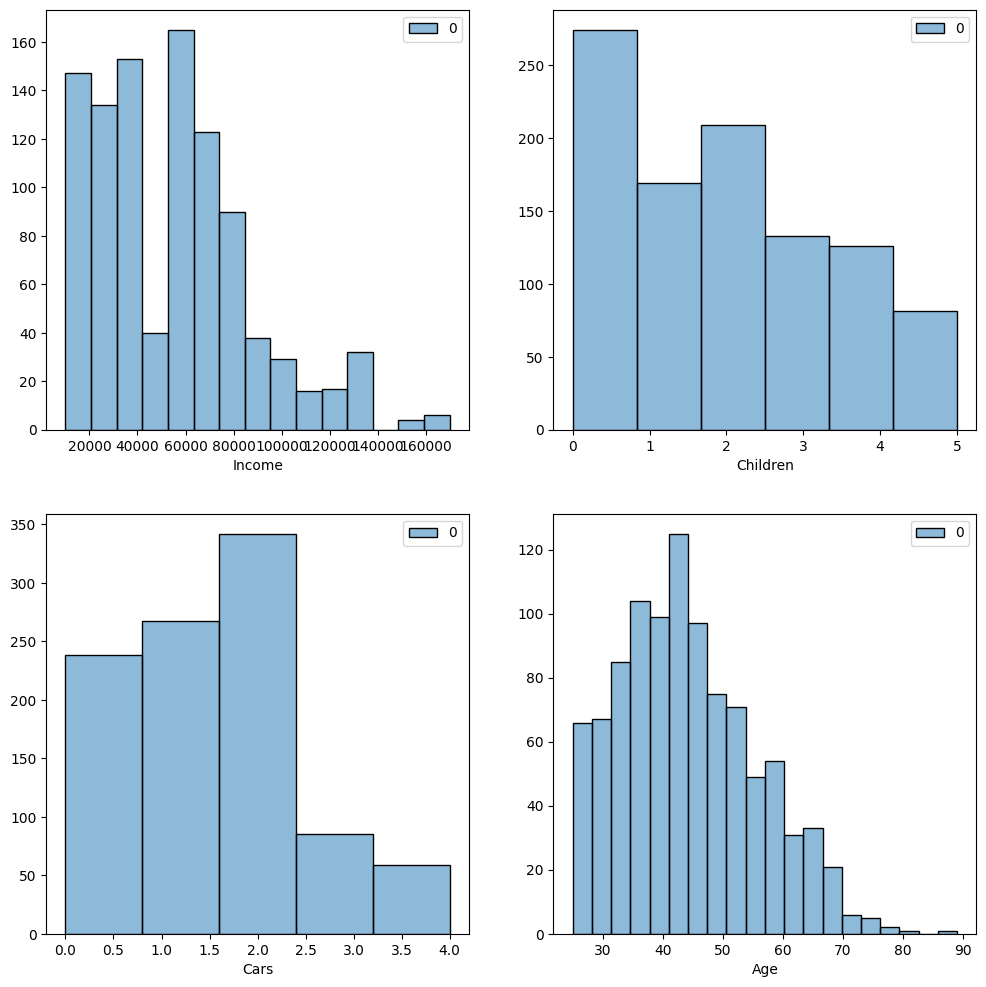

In [135]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
sns.histplot(
    X_numerical.select('Income'), 
    ax=ax[0, 0],
    bins=15 # потому что без бинс их примерно 15
).set(xlabel='Income', ylabel='')
sns.histplot(
    X_numerical.select('Children'), 
    ax=ax[0, 1],
    bins=6 # потому что без бинс их 6
).set(xlabel='Children', ylabel='')
sns.histplot(
    X_numerical.select('Cars'), 
    ax=ax[1, 0],
    bins=5 # потому что без бинс их 5
).set(xlabel='Cars', ylabel='')
sns.histplot(
    X_numerical.select('Age'), 
    ax=ax[1, 1],
    bins=20 # потому что без бинс их 20
).set(xlabel='Age', ylabel='')

распределения скошены - берем медиану

In [136]:
X_numerical = X_numerical.with_columns(pl.all().fill_null(pl.all().median()))

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [137]:
unique_values_all = X_numerical.select([pl.col(c).n_unique().alias(c + '_unique') for c in X_numerical.columns])
print(unique_values_all)

shape: (1, 4)
┌───────────────┬─────────────────┬─────────────┬────────────┐
│ Income_unique ┆ Children_unique ┆ Cars_unique ┆ Age_unique │
│ ---           ┆ ---             ┆ ---         ┆ ---        │
│ u32           ┆ u32             ┆ u32         ┆ u32        │
╞═══════════════╪═════════════════╪═════════════╪════════════╡
│ 16            ┆ 6               ┆ 5           ┆ 53         │
└───────────────┴─────────────────┴─────────────┴────────────┘


In [ ]:
X_ = df.drop('ID', 'Purchased Bike')
y_ = (df['Purchased Bike'] == 'Yes').cast(pl.Int32)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y)

def какойто_transform(X, C):
    X_tmp = X
    data = pl.concat([X_, y_.to_frame()], how='horizontal') # чтобы не было переобучения
    globalMean = y_train.mean()
    for category in X.columns:
        groups = data.group_by(category).agg([(pl.col('Purchased Bike').sum()).alias('sum'), (pl.len()).alias('count')])
        groups = groups.with_columns(((pl.col('sum') + C * globalMean) / (pl.col('count') + C)).alias('globalMean_' + category))
        X_tmp = X_tmp.join(groups, on = category, how='left').drop(category, 'sum', 'count').rename({'globalMean_' + category : category})
    return X_tmp.to_pandas()


In [155]:
какойто_logistic = LogisticRegression(random_state=42)

start5 = time.time()
X_train_transformed = какойто_transform(X_train, best_C)
X_train_transformed = X_train_transformed.fillna(0)
model = какойто_logistic.fit(X_train_transformed, y_train)
end5 = time.time()

X_test_transformed = какойто_transform(X_test, best_C)
X_test_transformed = X_test_transformed.fillna(0)
y_pred_какойто = model.decision_function(X_test_transformed)

print(f'AUC-PR для того что мы натворили: {average_precision_score(y_test, y_pred_какойто):.4f}')
print(f'время работы: {(end5 - start5):.4f}')

AUC-PR для того что мы натворили: 0.7248
время работы: 0.0151


ну стало ещё лучше, хватит

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ из плюсов, тратит меньше памяти соответсвенно меньше вермени, можно усреднять модели. Из минусов мы пользуемся данными из всего y, а значит утечка данных небольшая, но присутсвует

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-30 14:45:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data»

adult.data              [             <=>    ]   3,79M  1,35MB/s    за 2,8s    

2024-11-30 14:45:48 (1,35 MB/s) - «adult.data» сохранён [3974305]



In [174]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
24846,47,Private,266275,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States,0


каааак бы сильно я не любил polars, переделывать одно в другое в этой домашке неописуемо ужасно, пусть уж дальше будет только pandas

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [186]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [187]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('numeric', 'passthrough', numeric)
])
pipeline1 = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', LogisticRegression())
])
X_train_ohe = column_transformer.fit_transform(X_train)
X_test_ohe = column_transformer.transform(X_test)
X_train_ohe.shape[1]

108

ну у нас теперь 108 признаков

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

OHE metrics
AUC-PR: 0.4504
AUC-ROC: 0.5690


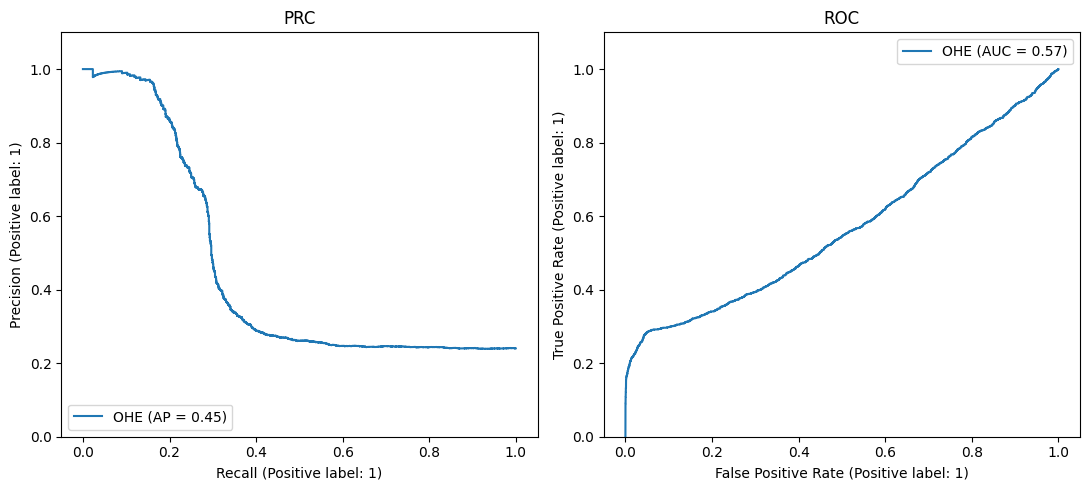

In [188]:
model = pipeline1.fit(X_train, y_train)
prediction = model.decision_function(X_test)
depict_pr_roc(y_test, prediction, 'OHE')

ну такое...

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [202]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



time: 0.0827
[ 37 106  31  35   9  19  23  30  49   5  38  39  10  52   0  32  55  21
  33  57  42  18  24  51  59  36  25 102  40 104  99  20   4  50  48  58
  47  29  27 107]
embedded method metrics
AUC-PR: 0.6742
AUC-ROC: 0.8817


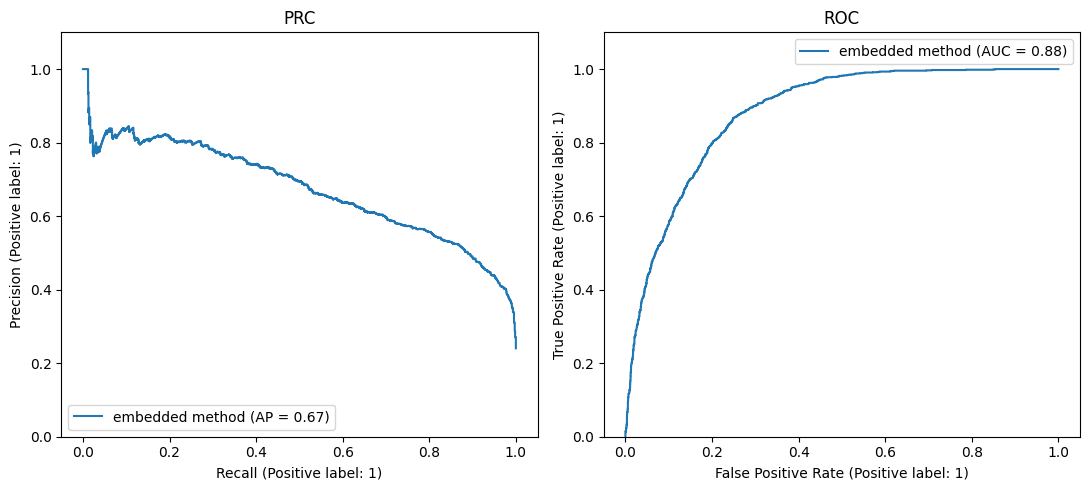

In [210]:
X_train_t = column_transformer.fit_transform(X_train1)
X_val_t = column_transformer.transform(X_val1)

start6 = time.time()
model2 = pipeline1.fit(X_train1, y_train1)
step = model2.steps[-1][1]
coef = step.coef_[0]
best_coef = np.argsort(np.abs(coef))[-40:]
end6 = time.time()

# не могу использовать pipeline поскольку уже там будут другие столбцы
model_best_coef = LogisticRegression(max_iter=10000)
model_best_coef.fit(X_train_t[:, best_coef], y_train1)
y_pred_best_coef = model_best_coef.decision_function(X_val_t[:, best_coef])
print(f'time: {(end6 - start6):.4f}')
print(best_coef)
depict_pr_roc(y_val1, y_pred_best_coef, 'embedded method')

Изменилось ли качество? Как?

ну качество заметно улучшилось, но не очень сильно наверно?(хотя это мой лучший результат), внизу кстати написано почему

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC_PR для всех отскейленых признаков: 0.749892
aAUC_PR для лучших сорока: 0.731355
[ 88  12  38  56  96  70  87  65  25  42 100   1   8  28  40  82  45  67
 104  61  43  71  13  90  66  49  36  22  58  30  62  50  37  52  29  27
  64  26  41 105]
top 40 scaled metrics
AUC-PR: 0.7314
AUC-ROC: 0.8928


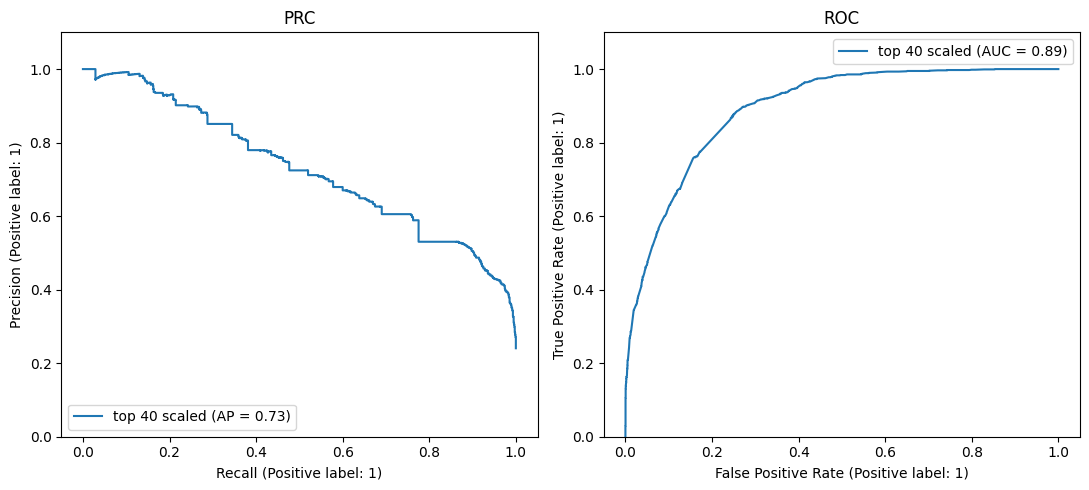

In [212]:
from sklearn.preprocessing import StandardScaler
column_transformer2 = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline2 = Pipeline(steps=[
    ('ohe', column_transformer2),
    ('regression', LogisticRegression())
])

model3 = pipeline2.fit(X_train1, y_train1)
y_pred_all = model3.decision_function(X_val1)
print(f'AUC_PR для всех отскейленых признаков: {average_precision_score(y_val1, y_pred_all):.6f}')

reg = model3.steps[-1][1]
coef = reg.coef_[0]
best_coef2 = (np.argsort(np.abs(coef)))[-40:]

model_final_b_c = LogisticRegression(max_iter=10000)
X_train_t2 = column_transformer2.fit_transform(X_train1)
X_val_t2 = column_transformer2.transform(X_val1)
model_final_b_c.fit(X_train_t2[:, best_coef2], y_train1)
y_pred_final = model_final_b_c.decision_function(X_val_t2[:, best_coef2])

print(f'aAUC_PR для лучших сорока: {average_precision_score(y_val1, y_pred_final):.6f}')
print(best_coef2)
depict_pr_roc(y_val1, y_pred_final, 'top 40 scaled')

ну стало прям хорошо, еще на 0.06 улучшили

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

AUC-PR уже всё применили: 0.7471
[ 66  51  39  44  43  14   6  49  45  64   9  38  88   1   8  10  23  19
  18  48  21  30  42  37  25  58  59  40  36  52  50 106 102 104 107  41
  22  29  27 105]
top 40 scaled all metrics
AUC-PR: 0.7471
AUC-ROC: 0.9015


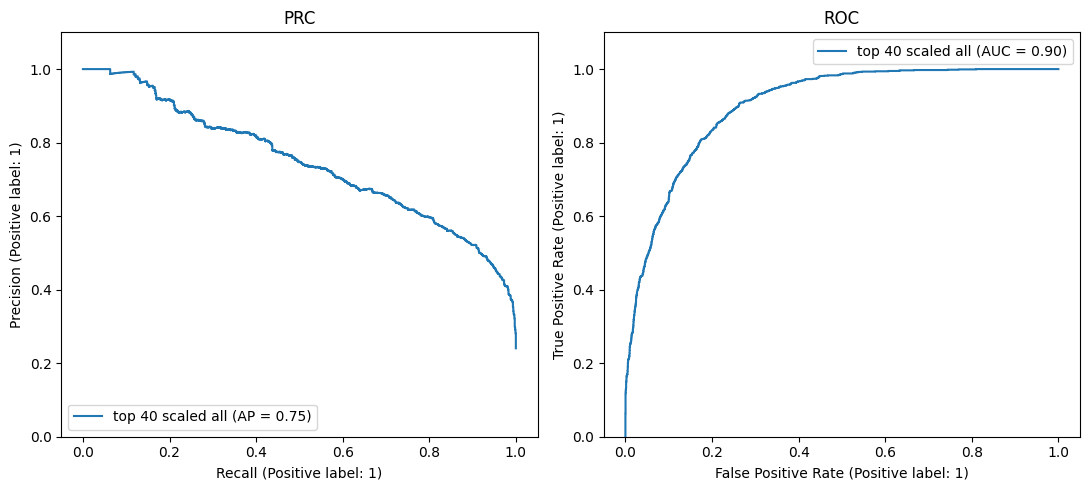

In [218]:
column_transformer_ohe = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('numeric', 'passthrough', numeric)
])
X_train_ohe = column_transformer_ohe.fit_transform(X_train1)
# нужен отдельный, чтобы показать что по всем новым столбцам, а названия я их не знаю, чтобы заранее писать
column_transformer_scale = ColumnTransformer([
   ('scaling', StandardScaler(with_mean=False), slice(X_train_ohe.shape[1])),
])

model4 = LogisticRegression(max_iter=10000)
X_train_t3 = column_transformer_scale.fit_transform(X_train_ohe)
model4.fit(X_train_t3, y_train1)

coef = model4.coef_[0]
best_coef3 = np.argsort(np.abs(coef))[-40:]

model_просто_всё = LogisticRegression(max_iter=10000)
model_просто_всё.fit(X_train_t3[:, best_coef3], y_train1)
X_val_ohe = column_transformer_ohe.transform(X_val1)
X_val_t3 = column_transformer_scale.transform(X_val_ohe)
y_pred_просто_всё = model_просто_всё.decision_function(X_val_t3[:, best_coef3])
print(f'AUC-PR уже всё применили: {average_precision_score(y_val1, y_pred_просто_всё):.4f}')
print(best_coef3)
depict_pr_roc(y_val1, y_pred_просто_всё, 'top 40 scaled all')

ещё немного выросли показатели, список очевидно поменялся

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** ну чем больше модуль корреляцией, тем больше линейная связть между признаком и таргетом, значит если их оставлять - предсказательная способность модели улучшится

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



AUC-PR с отбором по корреляции: 0.6206
Время работы: 0.0277
top 40 correlation filter metrics
AUC-PR: 0.6206
AUC-ROC: 0.8625


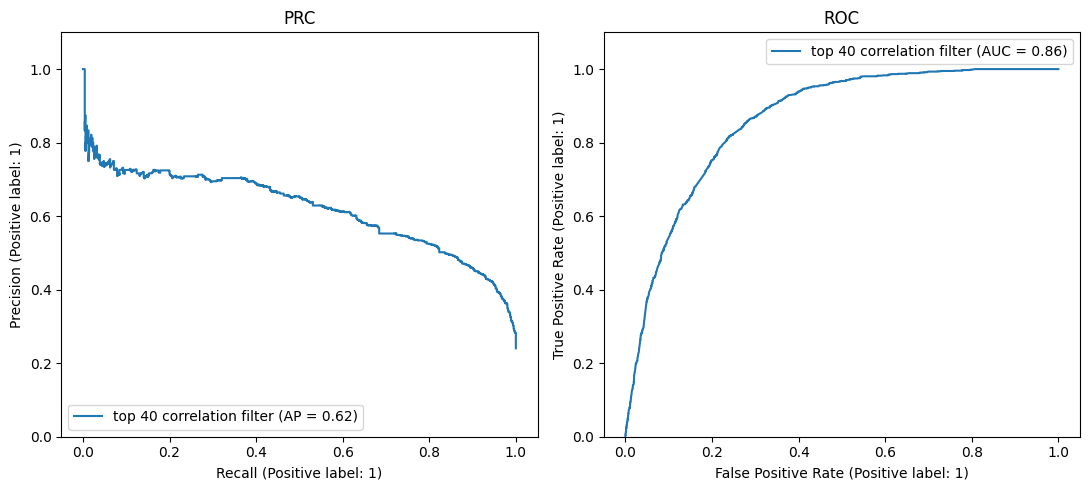

In [225]:
start7 = time.time()
# gpt подсказал, чтобы можно было корреляцию взять
X_train_t4 = pd.DataFrame(X_train1, columns=column_transformer_ohe.get_feature_names_out())
X_val_t4 = column_transformer_ohe.transform(X_val1)
corr = X_train_t4.corrwith(y_train1)
best_coef4 = np.argsort(abs(np.array(corr)))[-40:]
end7 = time.time()

model_corr = LogisticRegression(max_iter=10000)
model_corr.fit(X_train_ohe[:, best_coef4], y_train1)
y_pred_corr = model_corr.decision_function(X_val_t4[:, best_coef4])
print(f'AUC-PR с отбором по корреляции: {average_precision_score(y_val1, y_pred_corr):.4f}')
print(f'Время работы: {(end7 - start7):.4f}')
depict_pr_roc(y_val1, y_pred_corr, 'top 40 correlation filter')

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

AUC-PR с отбором по t-статистике: 0.4709
Время работы: 0.0391
top 40 t-statistic filter metrics
AUC-PR: 0.4709
AUC-ROC: 0.6035


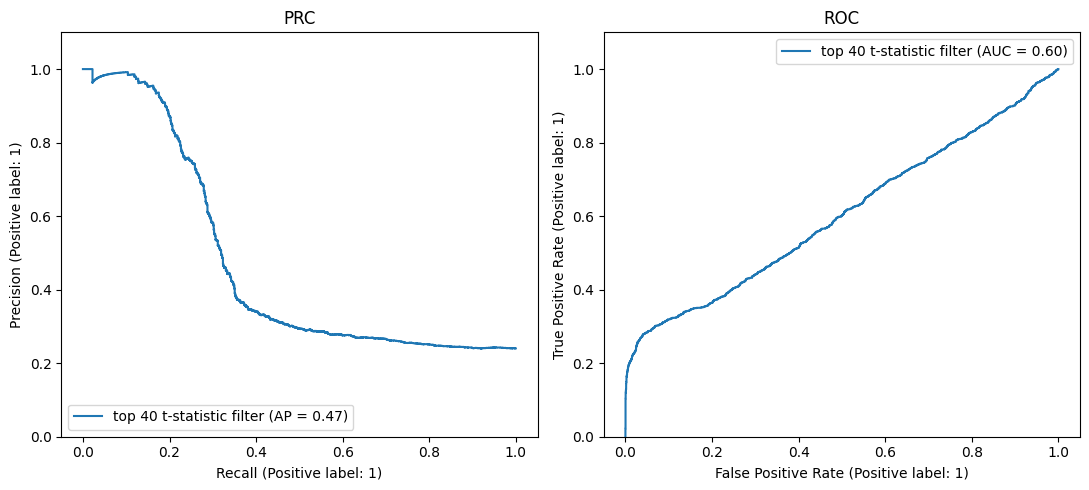

In [237]:
start8 = time.time()
X_train_t5 = column_transformer_ohe.transform(X_train1)
X_val_t5 = column_transformer_ohe.transform(X_val1)
mu_plus = np.mean(X_train_t5[y_train1 == 1], axis=0)
mu_minus = np.mean(X_train_t5[y_train1 == 0], axis=0)
sigma_plus2 = np.var(X_train_t5[y_train1 == 1].toarray(), axis=0)
sigma_minus2 =  np.var(X_train_t5[y_train1 == 0].toarray(), axis=0)
n_plus = X_train_t5.shape[0]
n_minus = X_train_t5.shape[0]

t_statistic = (np.abs(mu_plus - mu_minus) / np.sqrt((n_plus * sigma_plus2**2 + n_minus * sigma_minus2**2) / (n_plus + n_minus)))

best_coef5 = np.asarray(np.argsort(t_statistic)[-40:])[0]
end8 = time.time()

model_t = LogisticRegression(max_iter=10000)
model_t.fit(X_train_t5[:, best_coef5], y_train1)
y_pred_t = model_t.decision_function(X_val_t5[:, best_coef5])
print(f'AUC-PR с отбором по t-статистике: {average_precision_score(y_val1, y_pred_t):.4f}')
print(f'Время работы: {(end8 - start8):.4f}')
depict_pr_roc(y_val1, y_pred_t, 'top 40 t-statistic filter')

получилось не очень

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

Признаков достаточно много и достаточно равномерные корреляции, будем удалять их по несколько сразу 

беру самую удачную модель OHE-Scaling

In [261]:
column_transformer_ohe = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('numeric', 'passthrough', numeric)
])
X_train_ohe = column_transformer_ohe.fit_transform(X_train1)
# нужен отдельный, чтобы показать что по всем новым столбцам, а названия я их не знаю, чтобы заранее писать
column_transformer_scale = ColumnTransformer([
   ('scaling', StandardScaler(with_mean=False), slice(X_train_ohe.shape[1])),
])

X_train_t6 = column_transformer_scale.fit_transform(X_train_ohe)
X_val_ohe = column_transformer_ohe.transform(X_val1)
X_val_t6 = column_transformer_scale.transform(X_val_ohe)

features_cnt = X_train_t6.shape[1]
k = 40
m = 5 

start9 = time.time()
while features_cnt != k:
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_t6, y_train1)
    coef = model.coef_[0]
    
    M = min(X_train_t6.shape[1] - k, m)
    best_coef6 = np.argsort(np.abs(coef))[M - features_cnt:]
    
    X_train_t6 = X_train_t6[:, best_coef6]
    X_val_t6 = X_val_t6[:, best_coef6]
    features_cnt = X_train_t6.shape[1]
    print(f'Осталось: {features_cnt}')
    
end9 = time.time()
    
print(f'время работы: {(end9 - start9)}')

Осталось: 103
Осталось: 98
Осталось: 93
Осталось: 88
Осталось: 83
Осталось: 78
Осталось: 73
Осталось: 68
Осталось: 63
Осталось: 58
Осталось: 53
Осталось: 48
Осталось: 43
Осталось: 40
время работы: 3.6949520111083984


AUC-PR с отбором по методу обёртки: 0.7476
ohe + all scaling down obertka metrics
AUC-PR: 0.7476
AUC-ROC: 0.9018


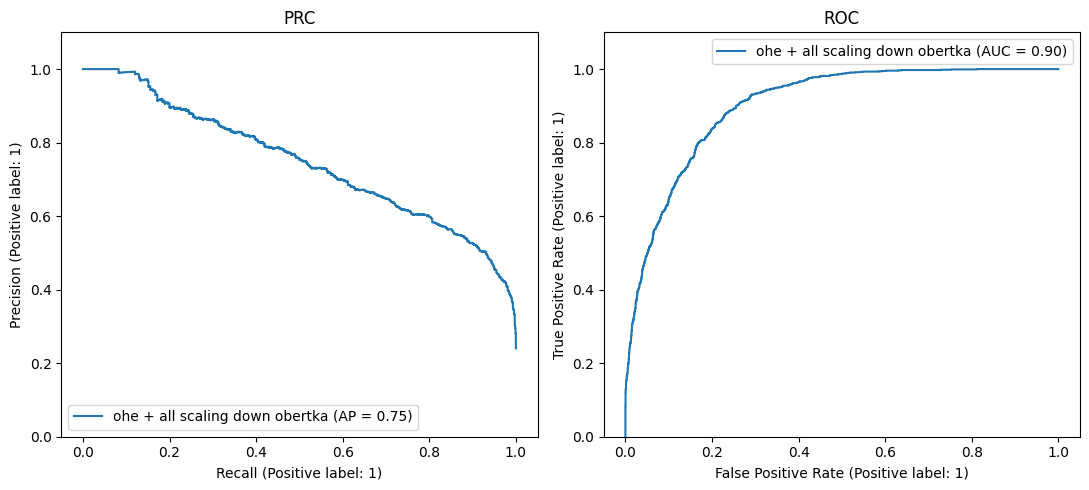

In [267]:
model_last = LogisticRegression(max_iter=10000)
model_last.fit(X_train_t6, y_train1)
y_pred_last = model_last.decision_function(X_val_t6)
print(f'AUC-PR с отбором по методу обёртки: {average_precision_score(y_val1, y_pred_last):.4f}')
depict_pr_roc(y_val1, y_pred_last, 'ohe + all scaling down obertka')

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [268]:
column_transformer_ohe = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('numeric', 'passthrough', numeric)
])
X_train_ohe = column_transformer_ohe.fit_transform(X_train1)
# нужен отдельный, чтобы показать что по всем новым столбцам, а названия я их не знаю, чтобы заранее писать
column_transformer_scale = ColumnTransformer([
    ('scaling', StandardScaler(with_mean=False), slice(X_train_ohe.shape[1]))
])

X_train_t7 = column_transformer_scale.fit_transform(X_train_ohe)
X_val_ohe = column_transformer_ohe.transform(X_val1)
X_val_t7 = column_transformer_scale.transform(X_val_ohe)

features_cnt = 0
k = 40  
m = 4

start10 = time.time()
best_coef_list = np.empty(0)
while features_cnt != k:
    model = LogisticRegression(max_iter=10000, random_state=42)
    model.fit(X_train_t7, y_train1)
    
    coef = model.coef_[0]
    best_coef7 = np.argsort(np.abs(coef))[-m:]  
    last_coef = np.argsort(np.abs(coef))[:-m]   
    best_coef_list = np.append(best_coef_list, best_coef7)
    features_cnt += m
    
    X_train_t7 = X_train_t7[:, last_coef]
    X_val_t7 = X_val_t7[:, last_coef]

    print(f'Добавлено: {features_cnt}')

end10 = time.time()

print(f'Время работы: {(end10 - start10):.4f} секунд')
print(best_coef_list)

Добавлено: 4
Добавлено: 8
Добавлено: 12
Добавлено: 16
Добавлено: 20
Добавлено: 24
Добавлено: 28
Добавлено: 32
Добавлено: 36
Добавлено: 40
Время работы: 1.4005 секунд
[ 22.  29.  27. 105.  97.  98.  63. 101.  77.  99.  96.  72.  86.  92.
  79.  93.  42.  17.  66.  84.  81.  83.  85.  82.  80.  81.  83.  82.
  76.  79.  74.  77.  59.  73.  71.  16.  69.  70.  71.  56.]


AUC-PR с добавлением по методу обёртки: 0.6209
ohe + full scaling up obertka metrics
AUC-PR: 0.6209
AUC-ROC: 0.8400


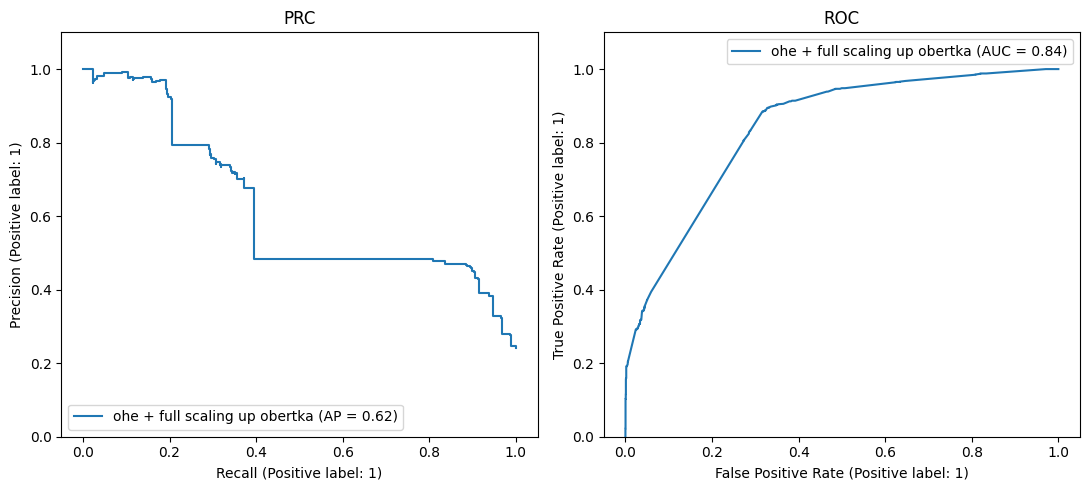

In [269]:
X_train_t8 = column_transformer_scale.transform(X_train_ohe)
X_val_ohe = column_transformer_ohe.transform(X_val1)
X_val_t8 = column_transformer_scale.transform(X_val_ohe)
X_train_add = X_train_t8[:, best_coef_list]
X_val_add = X_val_t8[:, best_coef_list]

model_last_reverse = LogisticRegression(max_iter=10000)
model_last_reverse.fit(X_train_add, y_train1)
y_pred_add = model_last_reverse.decision_function(X_val_add)
print(f'AUC-PR с добавлением по методу обёртки: {average_precision_score(y_val1, y_pred_add):.4f}')
depict_pr_roc(y_val1, y_pred_add, 'ohe + full scaling up obertka')

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
Встроенные методы довольно быстрые и дают хорошее качество, едиснвенное как понять сколько нам признаков оставить, а если оставлять много то занимет уже время. 

Методы фильтрации - просто быстрые. Показали самое плохое качество, также они рассматривают признаки по отдельности, наверно поэтому так неочень

Методы-обертки работают чуть дольше чем остальные, но в первом способе мы получили самое хорошее качество, также можно смотреть на изменение взаимосвязи во время удаления или добавления признаков

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [ ]:
# your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
# your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
# your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [ ]:
# your code here

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [ ]:
# your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here